# EDA

In [ ]:
#데이터 불러오기
import pandas as pd
data=pd.read_csv('/content/creditcard.csv')

In [ ]:
data.shape

(284807, 31)

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
#사기 거래수 확인
tmp=data['Class'].value_counts().to_frame().reset_index()                           #통계테이블을 pandas 데이터프레임으로 변환하여 조작하려는 경우(빈도수)
tmp['Percent(%)']=tmp["Class"].apply(lambda x : round(100*float(x) / len(data),2))   #람다: 익명함수, round: 반올림
tmp=tmp.rename(columns={"index":"Target", "Class":"Count"})

tmp

,Target,Count,Percent(%)
0,0,284315,99.83
1,1,492,0.17


# Data Preprocessing

In [ ]:
#Feature(x)과 Label(y) 분리
x_data=data.loc[:,'V1':'V28'] #V1~V28
y_data=data.loc[:,'Class'] #사기여부

print(x_data.shape)
print(y_data.shape)

(284807, 28)
(284807,)


In [ ]:
y_data

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

In [ ]:
#랜덤으로 Train, Test 데이터 나누기(7:3)
import numpy as np

shuffle_index=np.random.permutation(len(data)) #데이터를 랜덤으로 나눔
x_data=x_data.values[shuffle_index]
y_data=y_data.values[shuffle_index]

n_train=int(len(x_data)*0.7) #비율 7:3

x_train=x_data[:n_train] #데이터 분리
y_train=y_data[:n_train]
x_test=x_data[n_train:]
y_test=y_data[n_train:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(199364, 28)
(199364,)
(85443, 28)
(85443,)


In [ ]:
#Train, Test 데이터 분류(사기 여부에 따라)
pd.DataFrame([[sum(y_train==0), sum(y_test==0)],
              [sum(y_train==1), sum(y_test==1)]],
            columns=['train','test'], index=['0 (non-fraud)','1 (fraud)'])

,train,test
0 (non-fraud),199027,85288
1 (fraud),337,155


# Modeling

## 1. RamdomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=15) #결정트리 개수:15

model_rf.fit(x_train, y_train) #train 모델 학습

y_pred = model_rf.predict(x_test) #예측
y_real = y_test

In [ ]:
accuracy=round(sum(y_pred==y_real) / len(y_pred),4) #정분류율
precision=round(sum([p==1 & r==1 for p, r in zip(y_pred, y_real)]) / sum(y_pred==1),4) #정밀도 #zip: 자료형을 묶어주는 함수
recall=round(sum([p==1 & r==1 for p, r in zip(y_pred, y_real)]) / sum(y_real==1),4) #재현율
f1=round(2 / ((1/precision) + (1/recall)), 4) #F점수

print('Accuracy : ',accuracy)
print('Precision : ',precision)
print('Recall : ',recall)
print('f1=score : ',f1)
#정밀도 95%, 재현율(민감도) 79%, F점수 86%

Accuracy :  0.9996
Precision :  0.9493
Recall :  0.8452
f1=score :  0.8942


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_real, y_pred))

#정밀도 95%, 재현율(민감도) 79%, F점수 86% 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85288
           1       0.95      0.85      0.89       155

    accuracy                           1.00     85443
   macro avg       0.97      0.92      0.95     85443
weighted avg       1.00      1.00      1.00     85443



### 랜덤포레스트 시각화

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [ ]:
n_feature = 28

score_n_tr_est = []
score_n_te_est = []
score_m_tr_mft = []
score_m_te_mft = []

for i in np.arange(1, n_feature+1): # n_estimators와 mat_features는 모두 0보다 큰 정수여야 하므로 1부터 시작합니다.
    params_n = {'n_estimators':i, 'max_features':'auto', 'n_jobs':-1} # **kwargs parameter
    params_m = {'n_estimators':10, 'max_features':i, 'n_jobs':-1}

    forest_n = RandomForestClassifier(**params_n).fit(x_train, y_train)
    forest_m = RandomForestClassifier(**params_m).fit(x_train, y_train)

    score_n_tr = forest_n.score(x_train, y_train)
    score_n_te = forest_n.score(x_test, y_test)
    score_m_tr = forest_m.score(x_train, y_train)
    score_m_te = forest_m.score(x_test, y_test)

    score_n_tr_est.append(score_n_tr)
    score_n_te_est.append(score_n_te)
    score_m_tr_mft.append(score_m_tr)
    score_m_te_mft.append(score_m_te)

index = np.arange(len(score_n_tr_est))

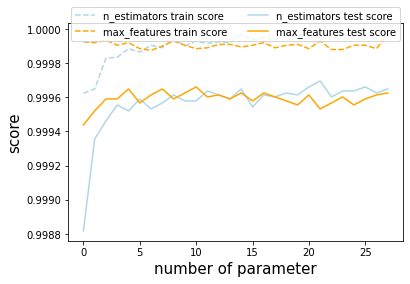

In [ ]:
plt.plot(index, score_n_tr_est, label='n_estimators train score', color='lightblue', ls='--') # ls: linestyle

plt.plot(index, score_m_tr_mft, label='max_features train score', color='orange', ls='--')

plt.plot(index, score_n_te_est, label='n_estimators test score', color='lightblue')

plt.plot(index, score_m_te_mft, label='max_features test score', color='orange')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),

           ncol=2, fancybox=True, shadow=False) # fancybox: 박스모양, shadow: 그림자

plt.xlabel('number of parameter', size=15)

plt.ylabel('score', size=15)

plt.show()

## 2. Logistic regression with Neural Network

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

n_inputs = x_train.shape[1] #입력 개수
n_output = 2 #출력 개수

#모델 생성
model_nn = tf.keras.Sequential([
    layers.Dense(64, input_shape=(n_inputs, ), activation='tanh'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(n_output, activation='softmax'),
])

#학습에 대한 설정
model_nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nn.summary()

#모델 적합
model_nn.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

#예측
y_pred=model_nn.predict(x_test)
y_real=y_test

Epoch 1/10
1994/1994 [==============================] - 4s 2ms/step - loss: 0.0714 - accuracy: 0.9688 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 2/10
1994/1994 [==============================] - 3s 2ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0027 - val_accuracy: 0.9994
Epoch 3/10
1994/1994 [==============================] - 3s 2ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0027 - val_accuracy: 0.9994
Epoch 4/10
1994/1994 [==============================] - 3s 2ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0026 - val_accuracy: 0.9993
Epoch 5/10
1994/1994 [==============================] - 3s 2ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0026 - val_accuracy: 0.9994
Epoch 6/10
1994/1994 [==============================] - 3s 2ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0023 - val_accuracy: 0.9994
Epoch 7/10
1994/1994 [==============================] - 3s 2ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0026 - val_accuracy:

In [ ]:
from sklearn.metrics import classification_report

y_pred = y_pred.argmax(axis=1)

accuracy=round(sum(y_pred == y_real) / len(y_pred), 4)

print('Accuracy : ',accuracy)
print(classification_report(y_real, y_pred))

#정밀도 88%, 재현율(민감도) 77%, F점수 82%

Accuracy :  0.9994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85301
           1       0.82      0.81      0.82       142

    accuracy                           1.00     85443
   macro avg       0.91      0.90      0.91     85443
weighted avg       1.00      1.00      1.00     85443



## 3. 오토인코더

입력 데이터와 출력 데이터를 같게 함. 

원본 데이터를 ecndoer를 통해 압축한 뒤 다시 decoder를 통해 복구.

비지도 학습 문제 해결(데이터를 압축함으로써 중요한 특징 탐색 가능)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sqlite3

data=pd.read_csv('/content/creditcard.csv')

# 데이터 정규화 -> 모든 값을 0과 1 사이 값으로
data_norm = (data - data.min()) / (data.max() - data.min())

#정상, 사기 거래 분류
fraud=data_norm[data_norm.Class==1] 
normal=data_norm[data_norm.Class==0]

#train, test 데이터 분할 (8:2)
# 학습은 normal data 80% 로만!
train=normal.sample(frac=0.8)
trainX=train.iloc[:,1:29].values

# 테스트는 20% 의 normal data 와 fraud data
test=normal.loc[~normal.index.isin(train.index)]
test=test.sample(frac=1)
testX=test.iloc[:,1:29].values

fraudX=fraud.iloc[:,1:29].values

normalX=normal.iloc[:,1:29].values


print('Total train :', trainX.shape[0])
print()

Total train : 227452



In [ ]:
trainY=train.iloc[:,30]
testY=test.iloc[:,30]
fraudY=fraud.iloc[:,30]
normalY=fraud.iloc[:,30]

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

X = tf.placeholder(tf.float32,[None, 28]) #input

# encoder
dense1 = tf.layers.dense(inputs=X, units = 20, activation = tf.nn.sigmoid)
dense2 = tf.layers.dense(inputs=dense1, units=14, activation=tf.nn.sigmoid)
encoder = tf.layers.dense(inputs=dense2,units=10,activation=tf.nn.sigmoid)

# decoder
dense4 = tf.layers.dense(inputs=encoder, units=14, activation=tf.nn.sigmoid)
dense5 = tf.layers.dense(inputs=dense4, units=20, activation=tf.nn.sigmoid)
decoder = tf.layers.dense(inputs=dense5, units=28, activation=tf.nn.sigmoid)

# optimizer
cost = tf.reduce_sum(tf.square(tf.subtract(decoder,X)))
optimizer = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
#training
def next_batch(data,i,batch):   
    return data[i*batch:i*batch+batch]
print('training')

with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer()) #변수초기화해야 연산작업 가능
    batch_size=500       
    total_train_batch=int(trainX.shape[0]/batch_size) #454
    for epoch in range(3):   
        total_cost=0      
        for i in range(total_train_batch):
            batch_xs = next_batch(trainX,i,batch_size)                   
            _, cost_val = sess.run([optimizer,cost],feed_dict={X:batch_xs})
            total_cost += cost_val    
        print('epoch:', epoch + 1, 'cost:', round(total_cost / total_train_batch,2))     
    print('train complete!')
    print() 
    print('testing..')

#testing      
    limit_list=[0.001,0.01,0.05,0.07,0.1,0.5]  

    for limit in limit_list:        
     fraud_count = 0
     normal_count = 0

    print('임계값 :', 0.05)

    a_list=[]
    b_list=[]
     
    for i in range(len(fraud)):      
       a=sess.run(cost,feed_dict={X:fraudX[i].reshape(1,28)})       
       if a >= 0.05:       
        fraud_count +=1           
        a_list.append(fraudX[i])

       for i in range(len(testX[0].shape)):       
           b=sess.run(cost,feed_dict={X:testX[i].reshape(1,28)})           
           if b >= 0.05:           
            normal_count +=1            
            b_list.append(b)
                           
    print('fraud :', fraud_count,'/',len(fraud), 'normal :', normal_count,'/',len(testX))

training
epoch: 1 cost: 75.08
epoch: 2 cost: 24.43
epoch: 3 cost: 24.13
train complete!

testing..
임계값 : 0.05
fraud : 462 / 492 normal : 0 / 56863
